# <center> Tweets Analysis</center>

## Dataset
    - Tweets Airlines Sentiments
        - Classify tweets by sentiment


In [1]:
# Before we begin, we supress deprecation warnings resulting from nltk on Kaggle
import warnings
import gensim
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [10]:
import pandas as pd
data= pd.read_csv("Tweets.csv")
list(tweets.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [11]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [13]:
data_group = tweets.groupby(["airline", "airline_sentiment" ]).count()["name"]
data_group

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: name, dtype: int64

In [15]:
data_companySentiment = data_group.to_frame().reset_index()
data_companySentiment.columns = ["airline", "airline_sentiment", "count"]
data_companySentiment

,airline,airline_sentiment,count
0,American,negative,1960
1,American,neutral,463
2,American,positive,336
3,Delta,negative,955
4,Delta,neutral,723
5,Delta,positive,544
6,Southwest,negative,1186
7,Southwest,neutral,664
8,Southwest,positive,570
9,US Airways,negative,2263


In [19]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [20]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
data['normalized_tweet'] = data.text.apply(normalizer)
data[['text','normalized_tweet']].head()

,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[added, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [21]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 7           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [23]:
from gensim.models import word2vec
model = word2vec.Word2Vec(data.normalized_tweet, workers=num_workers, \
                          size=num_features, min_count = min_word_count, \
                          window = context, sample = downsampling)
model.init_sims(replace=True)

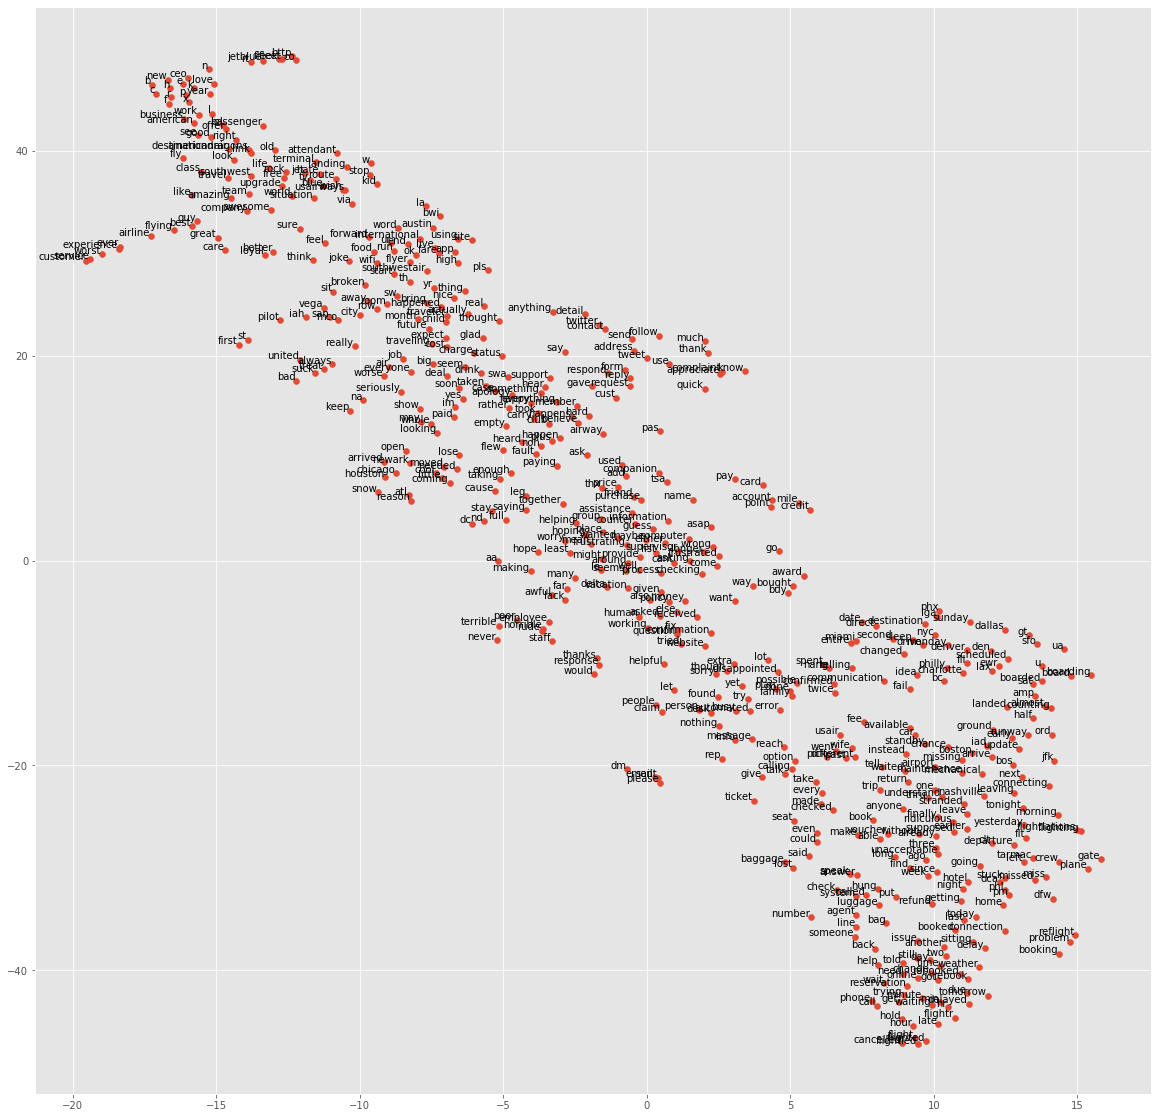

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X = model[model.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
labels = list(model.wv.vocab.keys())
for label, x, y in zip(labels, X_tsne[:, 0], X_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, -1),
        textcoords='offset points', ha='right', va='bottom')

plt.show()